In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


from yellowbrick.cluster import KElbowVisualizer

# Data analysis and preparation

In [2]:
df = pd.read_csv("weather_classification_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [3]:
print(df["Cloud Cover"].unique())
print(df["Season"].unique())
print(df["Location"].unique())
print(df["Weather Type"].unique())

['partly cloudy' 'clear' 'overcast' 'cloudy']
['Winter' 'Spring' 'Summer' 'Autumn']
['inland' 'mountain' 'coastal']
['Rainy' 'Cloudy' 'Sunny' 'Snowy']


In [4]:
df["Cloud Cover"] = df["Cloud Cover"].map({
    'clear': 0,
    'partly cloudy': 1,
    'cloudy': 2,
    'overcast':3,     
})

df["Season"] = df["Season"].map({
    'Winter': 0,
    'Spring': 1, 
    'Summer': 2,
    'Autumn': 3,
})

df["Location"] = df["Location"].map({
    'inland': 0,
    'mountain': 1,
    'coastal': 2,
})

print(df.dtypes)

Temperature             float64
Humidity                  int64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover               int64
Atmospheric Pressure    float64
UV Index                  int64
Season                    int64
Visibility (km)         float64
Location                  int64
Weather Type             object
dtype: object


### Outlier detection methods

In [5]:
features = ["Temperature", "Humidity", "Wind Speed", 
            "Precipitation (%)", "Cloud Cover", 
            "Atmospheric Pressure", "UV Index", 
            "Season", "Visibility (km)", "Location"]

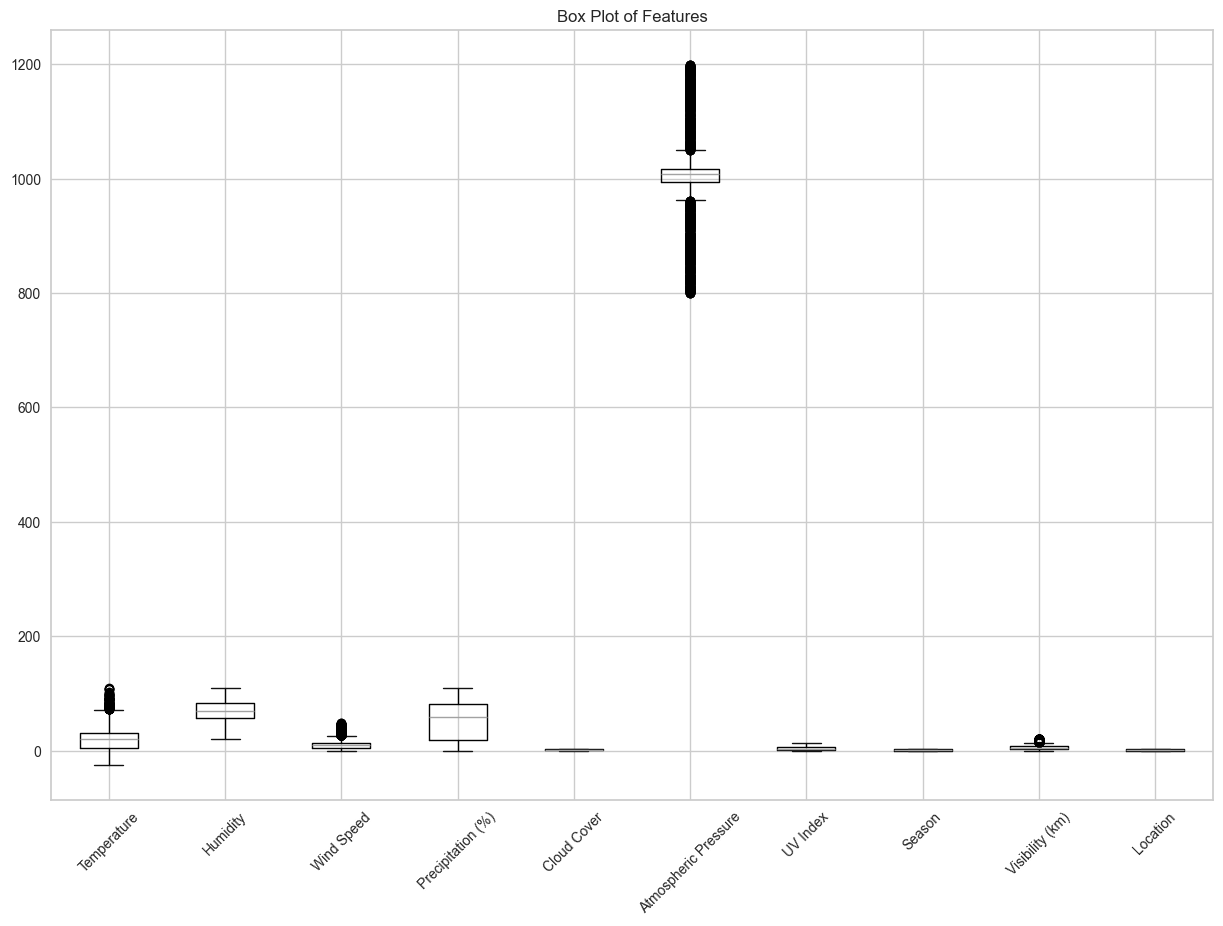

In [6]:
# Визуализация выбросов с помощью box plot

plt.figure(figsize=(15, 10))
df[features].boxplot()
plt.xticks(rotation=45)
plt.title("Box Plot of Features")
plt.show()

In [7]:
from scipy import stats

# Обнаружение выбросов с использованием Z-оценки
z_scores = np.abs(stats.zscore(df[features]))
threshold = 3
outliers_z = np.where(z_scores > threshold)

# Обнаружение выбросов с использованием IQR
Q1 = df[features].quantile(0.25)
Q3 = df[features].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df[features] < (Q1 - 1.5 * IQR)) | (df[features] > (Q3 + 1.5 * IQR))).sum()

print("Number of outliers by Z-score:", len(outliers_z[0]))
print("Number of emissions by IQR:", outliers_iqr)

Number of outliers by Z-score: 1166
Number of emissions by IQR: Temperature              92
Humidity                  0
Wind Speed              404
Precipitation (%)         0
Cloud Cover               0
Atmospheric Pressure    927
UV Index                  0
Season                    0
Visibility (km)         383
Location                  0
dtype: int64


The number of outliers detected by two different methods: Z-score and the interquartile range (IQR) method.

**Z-score:**

- 1166 outliers detected.
- This method considers all features together and considers any data point that deviates more than 3 standard deviations from the mean in any feature as an outlier.


**IQR Method:**

- This method analyzes each feature separately:
    - Temperature: 92 outliers
    - Wind Speed: 404 outliers
    - Atmospheric Pressure: 927 outliers
    - Visibility (km): 383 outliers
- The remaining features (Humidity, Precipitation (%), Cloud Cover, UV Index, Season, Location) do not have any outliers according to the IQR method.


Kоличество выбросов, обнаруженных двумя различными методами: Z-оценкой и методом межквартильного размаха (IQR).

**Z-оценка:**  
- Обнаружено 1166 выбросов.
- Этот метод рассматривает все признаки вместе и считает выбросом любую точку данных, которая отклоняется более чем на 3 стандартных отклонения от среднего значения по любому из признаков.  

**Метод IQR:**  
- Этот метод анализирует каждый признак отдельно:
    - Temperature: 92 выброса
    - Wind Speed: 404 выброса
    - Atmospheric Pressure: 927 выбросов
    - Visibility (km): 383 выброса
- Остальные признаки (Humidity, Precipitation (%), Cloud Cover, UV Index, Season, Location) не имеют выбросов по методу IQR.

In [8]:
# Уникальные значения температуры
unique_temperatures = df["Temperature"].unique()
print(unique_temperatures)

[ 14.  39.  30.  38.  27.  32.  -2.   3.  28.  35.  12. -10.  24.  10.
  33.  43.  13.  -7.  26.   4.  17.  40.   2.  15.  29.  11.  -9.  36.
  42.  21.  22.  25.  -4.  -1.  -5.  41.  31.  16.  34.  49.  19.  23.
  20.  -3.  18.   1.   0.  46.  44. -13.  -6.  78.  63.  73.   8. -12.
 -24.  -8.  60.  48.   5.  51. -14.  50.  37.  54.  47.  70.   9.  66.
 -16. -15.  59.  80. -19.  52.  45.   6. -18. -11.  74.  76.  55. -20.
  57.  91.  82. -17.  61.   7.  53.  65.  77.  67.  64.  58.  68.  72.
  62.  71.  56. 107. -22.  75.  85.  97.  84. -21.  92. -25.  81. 109.
  98.  94.  90. -23.  88.  99.  69. 100.  89. 102.  86. 108.  87.  95.]


# Training on the output of normalized data

## Baseline

In [9]:
scaler = StandardScaler()
ndata = df.copy()
ndata[features] = scaler.fit_transform(ndata[features])

X_train, X_test, y_train, y_test = train_test_split(
    ndata[features], 
    ndata["Weather Type"],
    test_size=0.3,
    stratify=ndata["Weather Type"]
    )


In [20]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Model accuracy Random Forest:", rf_accuracy)

Random Forest - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.87      0.90      0.88       990
       Rainy       0.91      0.90      0.90       990
       Snowy       0.93      0.93      0.93       990
       Sunny       0.92      0.90      0.91       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

Model accuracy Random Forest: 0.9078282828282829


In [11]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Оценка модели
print("Gradient Boosting - Classification Report")
print(classification_report(y_test, y_pred_gb))
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print("Model accuracy Gradient Boosting:", gb_accuracy)

Gradient Boosting - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.89      0.90      0.89       990
       Rainy       0.89      0.90      0.90       990
       Snowy       0.94      0.93      0.94       990
       Sunny       0.92      0.91      0.91       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

Model accuracy Gradient Boosting: 0.9095959595959596


## Winsorization method

**Метод винзоризации** - это статистический метод обработки данных, используемый для уменьшения влияния выбросов (экстремальных значений) на анализ.   
**Основные характеристики метода:**  
- Суть метода:
    - Заключается в замене экстремальных значений в наборе данных на менее экстремальные.
    - Крайние значения (обычно верхние и нижние 5% или 1%) заменяются на значения заданных процентилей.
- Цель применения:
    - Снижение влияния выбросов на статистические показатели и анализ.
    - Сохранение структуры данных без полного удаления экстремальных значений.
- Преимущества:
    - Позволяет сохранить объем выборки, не удаляя наблюдения полностью.
    - Уменьшает искажающее влияние экстремальных значений на результаты анализа.
- Процесс:
    - Определяются верхний и нижний пороги (например, 1-й и 99-й процентили).
    - Значения ниже нижнего порога заменяются на значение нижнего порога.
    - Значения выше верхнего порога заменяются на значение верхнего порога.
- Особенности:
    - Степень винзоризации (процент заменяемых значений) может варьироваться в зависимости от специфики данных и целей исследования.
    - Метод сохраняет информацию о наличии экстремальных значений, в отличие от простого удаления выбросов.  

    
Винзоризация является эффективным методом обработки данных, особенно когда важно сохранить объем выборки и при этом уменьшить влияние экстремальных значений на результаты анализа.

In [12]:
def winsorize_feature(data, feature, limits=(0.01, 0.99)):
    return pd.Series(stats.mstats.winsorize(data[feature], limits=limits), index=data.index)

# Применение винзоризации
df_copy = df.copy()
df_copy['Atmospheric Pressure'] = winsorize_feature(df_copy, 'Atmospheric Pressure')
df_copy['Wind Speed'] = winsorize_feature(df_copy, 'Wind Speed')
df_copy['Visibility (km)'] = winsorize_feature(df_copy, 'Visibility (km)')

# Для температуры можно использовать более мягкие ограничения
df_copy['Temperature'] = winsorize_feature(df_copy, 'Temperature', limits=(0.005, 0.995))

In [13]:
df_copy[features] = scaler.fit_transform(df_copy[features])

# Разделение данных на обучающую и тестовую выборки
X_train_copy, X_test_copy, y_train_copy, y_test_copy = train_test_split(
    df_copy[features], 
    df_copy["Weather Type"],
    test_size=0.3,
    stratify=df["Weather Type"]
)

In [14]:
rf_model_w = RandomForestClassifier()
rf_model_w.fit(X_train_copy, y_train_copy)
y_pred_rf_w = rf_model.predict(X_test_copy)


print("Random Forest - Classification Report")
print(classification_report(y_test_copy, y_pred_rf_w))
rf_accuracy_w = accuracy_score(y_test_copy, y_pred_rf_w)
print("Model accuracy Random Forest:", rf_accuracy_w)

Random Forest - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.33      1.00      0.49       990
       Rainy       0.76      0.05      0.09       990
       Snowy       0.50      0.00      0.00       990
       Sunny       0.99      0.89      0.93       990

    accuracy                           0.48      3960
   macro avg       0.64      0.48      0.38      3960
weighted avg       0.64      0.48      0.38      3960

Model accuracy Random Forest: 0.48358585858585856


In [15]:
# Обучение модели Gradient Boosting
gb_model_w = GradientBoostingClassifier()
gb_model_w.fit(X_train_copy, y_train_copy)
y_pred_gb_w = gb_model.predict(X_test_copy)

print("Gradient Boosting - Classification Report")
print(classification_report(y_test_copy, y_pred_gb_w))
gb_accuracy_w = accuracy_score(y_test_copy, y_pred_gb_w)
print("Model accuracy Gradient Boosting:", gb_accuracy_w)

Gradient Boosting - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.32      1.00      0.48       990
       Rainy       0.00      0.00      0.00       990
       Snowy       0.00      0.00      0.00       990
       Sunny       0.99      0.84      0.91       990

    accuracy                           0.46      3960
   macro avg       0.33      0.46      0.35      3960
weighted avg       0.33      0.46      0.35      3960

Model accuracy Gradient Boosting: 0.46060606060606063


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Replacing outliers with median values:

In [16]:
# Функция для замены выбросов на медианные значения
def replace_outliers_with_median(data, feature, threshold=3):
    median = data[feature].median()
    z_scores = np.abs(stats.zscore(data[feature]))
    data.loc[z_scores > threshold, feature] = median
    return data

df_median = df.copy()
# Применение замены выбросов для каждого признака
for feature in features:
    df_median = replace_outliers_with_median(df_median, feature)

In [17]:
df_median[features] = scaler.fit_transform(df_median[features])

# Разделение данных на обучающую и тестовую выборки
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(
    df_median[features], 
    df_median["Weather Type"],
    test_size=0.3,
    stratify=df["Weather Type"]
)

# Обучение модели Random Forest
rf_model_med = RandomForestClassifier()
rf_model_med.fit(X_train_median, y_train_median)
y_pred_rf_med = rf_model_med.predict(X_test_median)

# Оценка модели
print("Random Forest - Classification Report")
print(classification_report(y_test_median, y_pred_rf_med))
rf_accuracy_med = accuracy_score(y_test_median, y_pred_rf_med)
print("Model accuracy Random Forest:", rf_accuracy_med)

Random Forest - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.88      0.91      0.90       990
       Rainy       0.90      0.92      0.91       990
       Snowy       0.94      0.92      0.93       990
       Sunny       0.94      0.91      0.92       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

Model accuracy Random Forest: 0.9138888888888889


In [18]:
# Обучение модели Gradient Boosting
gb_model_med = GradientBoostingClassifier()
gb_model_med.fit(X_train_median, y_train_median)
y_pred_gb_med = gb_model_med.predict(X_test_median)

# Оценка модели
print("Gradient Boosting - Classification Report")
print(classification_report(y_test_median, y_pred_gb_med))
gb_accuracy_med = accuracy_score(y_test_median, y_pred_gb_med)
print("Model accuracy Gradient Boosting:", gb_accuracy_med)

Gradient Boosting - Classification Report
              precision    recall  f1-score   support

      Cloudy       0.89      0.90      0.89       990
       Rainy       0.88      0.92      0.90       990
       Snowy       0.95      0.92      0.93       990
       Sunny       0.94      0.91      0.92       990

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

Model accuracy Gradient Boosting: 0.9121212121212121


# Results


## Baseline

**Random Forest**
Accuracy Random Forest: 0.9078282828282829
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.87      0.90      0.88       990
       Rainy       0.91      0.90      0.90       990
       Snowy       0.93      0.93      0.93       990
       Sunny       0.92      0.90      0.91       990

    accuracy                           0.91      3960
    macro avg       0.91      0.91     0.91      3960
    weighted avg    0.91      0.91     0.91      3960

**Gradient Boosting**
Accuracy Gradient Boosting: 0.9095959595959596
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.89      0.90      0.89       990
       Rainy       0.89      0.90      0.90       990
       Snowy       0.94      0.93      0.94       990
       Sunny       0.92      0.91      0.91       990

    accuracy                           0.91      3960
    macro avg       0.91      0.91     0.91      3960
    weighted avg    0.91      0.91     0.91      3960


далее обучение моделей с использованием
## Winsorization method


**Random Forest**
Accuracy Random Forest: 0.48358585858585856
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.33      1.00      0.49       990
       Rainy       0.76      0.05      0.09       990
       Snowy       0.50      0.00      0.00       990
       Sunny       0.99      0.89      0.93       990

    accuracy                           0.48      3960
    macro avg       0.64      0.48     0.38      3960
    weighted avg    0.64      0.48     0.38      3960


**Gradient Boosting**
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.32      1.00      0.48       990
       Rainy       0.00      0.00      0.00       990
       Snowy       0.00      0.00      0.00       990
       Sunny       0.99      0.84      0.91       990

    accuracy                           0.46      3960
    macro avg       0.33      0.46     0.35      3960
    weighted avg    0.33      0.46     0.35      3960

Accuracy Gradient Boosting: 0.46060606060606063


и последним был метод

## Replacing outliers with median values

**Random Forest**
Accuracy Random Forest: 0.9138888888888889
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.88      0.91      0.90       990
       Rainy       0.90      0.92      0.91       990
       Snowy       0.94      0.92      0.93       990
       Sunny       0.94      0.91      0.92       990

    accuracy                           0.91      3960
    macro avg       0.91      0.91     0.91      3960
    weighted avg    0.91      0.91     0.91      3960



**Gradient Boosting**
Accuracy Gradient Boosting: 0.9121212121212121
Classification Report
              precision    recall  f1-score   support

      Cloudy       0.89      0.90      0.89       990
       Rainy       0.88      0.92      0.90       990
       Snowy       0.95      0.92      0.93       990
       Sunny       0.94      0.91      0.92       990

    accuracy                           0.91      3960
    macro avg       0.91      0.91     0.91      3960
    weighted avg    0.91      0.91     0.91      3960




# Conclusion 

Based on the provided results, the following conclusions can be made:

**Comparison of Outlier Handling Methods:**

- a) Baseline Model (without outlier handling):

    - Random Forest: Accuracy 90.78%
    - Gradient Boosting: Accuracy 90.96%
- b) Winsorization Method:

    - Random Forest: Accuracy 48.36%
    - Gradient Boosting: Accuracy 46.06%
- c) Replacing Outliers with Median Values:

    - Random Forest: Accuracy 91.39%
    - Gradient Boosting: Accuracy 91.21%


**Analysis of Results:**

- a) The baseline model showed good results, indicating relatively high-quality initial data.
- b) The Winsorization method led to a significant decrease in the performance of both models. This may indicate that:
Outliers contain important information for weather classification.
Winsorization might have distorted the natural variability of weather conditions.
- c) Replacing outliers with median values gave the best results:
Slight but noticeable improvement compared to the baseline model.
More stable results across all weather classes.  

**Comparison of Models:**

- Random Forest and Gradient Boosting showed comparable results in all experiments.
- Random Forest slightly outperformed Gradient Boosting when using the method of replacing outliers with median values.


**Analysis by Weather Classes:**

- All models showed the best results for the "Snowy" class.
- The "Cloudy" class was the most difficult to classify, especially in the baseline model.


### **Conclusions:**

- The method of replacing outliers with median values was the most effective for this weather classification task. It improved model accuracy while retaining important information about weather conditions.
- Winsorization was an unsuitable method for this dataset, possibly due to the nature of weather data where extreme values can carry important information.
- Random Forest performed slightly better than Gradient Boosting, especially after handling outliers by replacing them with median values.


На основе предоставленных результатов можно сделать следующие выводы:

**Сравнение методов обработки выбросов:**
- a) Базовая модель (без обработки выбросов):
    - Random Forest: точность 90.78%
    - Gradient Boosting: точность 90.96%
- b) Метод винзоризации:
    - Random Forest: точность 48.36%
    - Gradient Boosting: точность 46.06%
- c) Замена выбросов медианными значениями:
    - Random Forest: точность 91.39%
    - Gradient Boosting: точность 91.21%

**Анализ результатов:**
- a) Базовая модель показала хорошие результаты, что указывает на относительно качественные исходные данные.
- b) Метод винзоризации привел к значительному ухудшению производительности обеих моделей. Это может указывать на то, что:
    - Выбросы содержат важную информацию для классификации погоды.
    - Винзоризация могла исказить естественную вариативность погодных условий.
c) Замена выбросов медианными значениями дала наилучшие результаты:
    - Незначительное, но заметное улучшение по сравнению с базовой моделью.
    - Более стабильные результаты по всем классам погоды.  


**Сравнение моделей:**  

- Random Forest и Gradient Boosting показали сопоставимые результаты во всех экспериментах.
- Random Forest немного превзошел Gradient Boosting при использовании метода замены выбросов медианными значениями.  


**Анализ по классам погоды:**
- Все модели показали наилучшие результаты для класса "Snowy" (Снежная погода).
- Класс "Cloudy" (Облачная погода) оказался наиболее сложным для классификации, особенно в базовой модели.  

**Выводы:**
- Метод замены выбросов медианными значениями оказался наиболее эффективным для данной задачи классификации погоды. Он позволил улучшить точность модели, сохранив при этом важную информацию о погодных условиях.
- Винзоризация оказалась неподходящим методом для этого набора данных, возможно, из-за специфики погодных данных, где экстремальные значения могут нести важную информацию.
- Random Forest показал себя немного лучше, чем Gradient Boosting, особенно после обработки выбросов методом замены на медианные значения.

